# Imports

Import das bibliotecas

In [154]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.preprocessing import label_binarize, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

Import do dataset

In [146]:
data = pd.read_csv('final_features_dataset.csv')

# Tratamento do Dataset

Divisão dos dados em X_train, X_test, y_train e y_test.
Os nódulos foram agrupados em grupos (cada grupo representa um paciente) e depois foram divididos, tendo em atenção que todos os nódulos do mesmo grupo foram agrupados no mesmo DataFrame.
Para além disso o X foi normalizado utilizando Standard Scaler para que no PCA todas as variáveis comecem com a mesma importância

In [147]:
data['group'] = data['nodule_id'].str[10:14]
groups = data['group']
X = data.drop(['malignancy', 'nodule_id', 'group'], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = data['malignancy']
X = pd.DataFrame(X)

gss = GroupShuffleSplit(test_size=0.3, n_splits=5, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

Gráfico de Scree para compreender a variância acumulada ao adicionar componentes ao PCA.
Referência: https://www.statology.org/scree-plot-python/

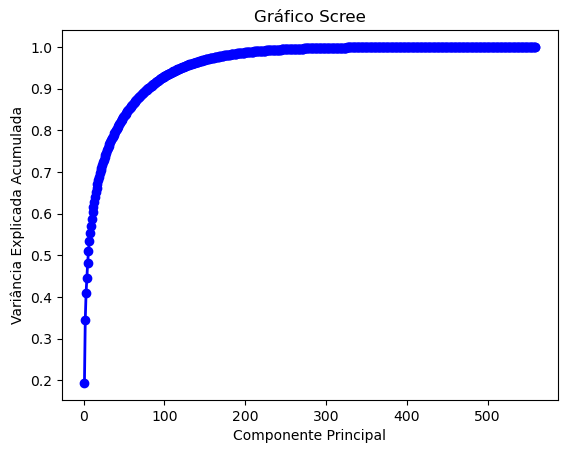

In [148]:
pca = PCA(n_components=559)
pca_fit = pca.fit(X)
X_pca = pca.transform(X)
var_explicada_acumulada = np.cumsum(pca.explained_variance_ratio_)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, var_explicada_acumulada, 'o-', linewidth=2, color='blue')
plt.title('Gráfico Scree')
plt.xlabel('Componente Principal')
plt.ylabel('Variância Explicada Acumulada')
plt.show()

Pela análise do primeiro gráfico conseguimos perceber que o número de componentes ideais para o PCA está entre 100 e 200, pois é onde a variância acumulada começa a perder declive, o que significa que com menos componentes perderíamos informação e com mais componentes corríamos o risco de overfitting

Segundo Gráfico de Scree (mais aproximado) para perceber exatamente onde está o número de componentes "ideal" para o PCA

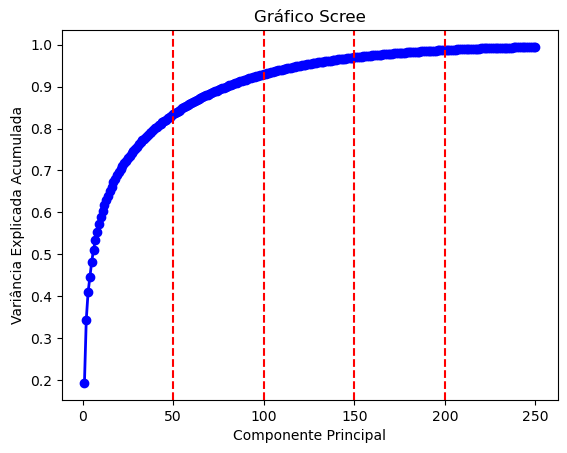

In [149]:
pca = PCA(n_components=250)
pca_fit = pca.fit(X)
X_pca = pca.transform(X)
var_explicada_acumulada = np.cumsum(pca.explained_variance_ratio_)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, var_explicada_acumulada, 'o-', linewidth=2, color='blue')
plt.title('Gráfico Scree')
plt.xlabel('Componente Principal')
plt.ylabel('Variância Explicada Acumulada')
for x in (50, 100, 150, 200):
    plt.axvline(x=x, color='red', linestyle='--')
plt.show()

Realização de PCA utilizando a biblioteca Sklearn, e com 150 componentes, valor que retirámos dos Gráficos de Scree acima. Daqui retiramos os novos X_train e X_test

In [150]:
pca = PCA(n_components=150) 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# XGBoost

Fine Tuning do XGBoost para o X_train usando a biblioteca Sklearn. Visto que no grid_search não é definido o 'scoring', o scoring é feito pela accuracy por default. Os valores do grid de parâmetros possíveis foram dados pelo ChatGPT através de contexto sobre o dataset (nº de componentes, tipo de classificação e modelo de classificação)

In [151]:
param_grid = {
    'max_depth': [4, 6],
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8], 
    'colsample_bytree': [0.7, 0.8], 
    'gamma': [0, 0.1, 0.2],  
    'min_child_weight': [1, 3],
}


xgb_classifier = xgb.XGBClassifier(random_state=42)

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, refit=True, cv=3, n_jobs=-1, verbose=3)

grid_search.fit(X_train_pca, y_train)

xgb = grid_search.best_estimator_

Fitting 3 folds for each of 192 candidates, totalling 576 fits
[CV 1/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=50, subsample=0.7;, score=0.742 total time=   0.3s
[CV 3/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=50, subsample=0.7;, score=0.717 total time=   0.3s
[CV 2/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=50, subsample=0.8;, score=0.742 total time=   0.3s
[CV 1/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7;, score=0.783 total time=   0.6s
[CV 3/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7;, score=0.729 total time=   0.7s
[CV 2/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.8;,

[CV 2/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=100, subsample=0.8;, score=0.733 total time=   0.5s
[CV 1/3] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=50, subsample=0.7;, score=0.754 total time=   0.4s
[CV 3/3] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=50, subsample=0.7;, score=0.725 total time=   0.3s
[CV 2/3] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=50, subsample=0.8;, score=0.742 total time=   0.3s
[CV 1/3] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7;, score=0.783 total time=   0.6s
[CV 3/3] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7;, score=0.729 total time=   0.6s
[CV 2/3] END colsample

[CV 1/3] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=50, subsample=0.8;, score=0.779 total time=   0.3s
[CV 3/3] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=50, subsample=0.8;, score=0.704 total time=   0.3s
[CV 2/3] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7;, score=0.742 total time=   0.6s
[CV 1/3] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.771 total time=   0.6s
[CV 3/3] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.717 total time=   0.6s
[CV 2/3] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=50, subsample=0.7;, score=0.738 total time=   0.3s
[CV 1/3] END colsam

[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7;, score=0.733 total time=   0.6s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.733 total time=   0.7s
[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=50, subsample=0.7;, score=0.750 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=50, subsample=0.7;, score=0.738 total time=   0.3s
[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=50, subsample=0.8;, score=0.767 total time=   0.3s
[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=50, subsample=0.8;, score=0.700 total time=   0.3s
[CV 2/3] END colsample_bytree=0.

[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.733 total time=   0.6s
[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=50, subsample=0.7;, score=0.692 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=50, subsample=0.8;, score=0.725 total time=   0.3s
[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.7;, score=0.775 total time=   0.5s
[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.7;, score=0.713 total time=   0.5s
[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.8;, score=0.738 total time=   0.5s
[CV 1/3] END colsa

Primeiro é feito um treino do modelo XGBoost afinado para accuracy com 5-cross validation, utilizando o X_train e o y_train. Depois o modelo é testado com X_test e y_test, e é a partir destes testes que se retiram as métricas que considerámos relevantes (matriz de confusão, accuracy, precision, recall, precision for negatives, recall for negatives, f1 score e log loss)

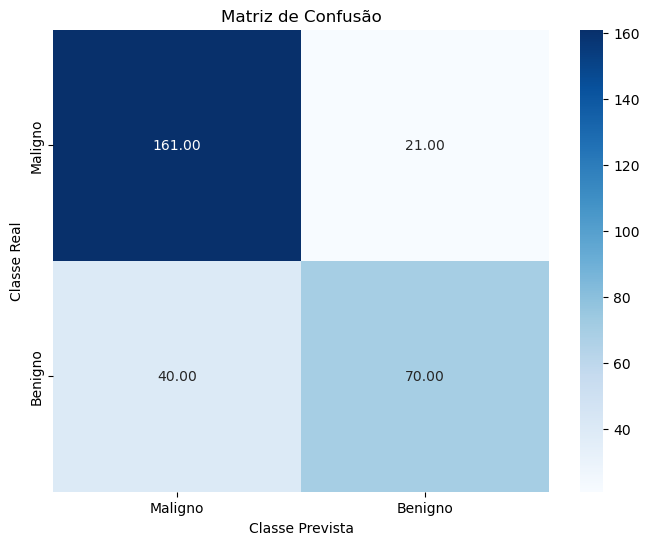


Accuracy: 0.79
Precision: 0.80
Recall: 0.88
Precision for negatives: 0.77
Recall for negatives: 0.64
F1 Score: 0.84
Average Log Loss: 0.45


In [152]:
model = xgb
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X_train_pca, y_train):
    X_train_fold, X_test_fold = X_train_pca.iloc[train_index], X_train_pca.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold)

y_pred = model.predict(X_test_pca)
y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    
conf_matrix = confusion_matrix(y_test, y_pred)
df_conf_matrix = pd.DataFrame(conf_matrix, index=['Maligno', 'Benigno'], columns=['Maligno', 'Benigno'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title('Matriz de Confusão')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()
print()

TP, FN, FP, TN = conf_matrix.ravel()

TP, FN, FP, TN = conf_matrix.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
precision_neg = TN / (TN + FN)
recall_neg = TN / (TN + FP)
f1 = 2 * (precision * recall) / (precision + recall)
average_log_loss = log_loss(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision for negatives: {precision_neg:.2f}")
print(f"Recall for negatives: {recall_neg:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Average Log Loss: {average_log_loss:.2f}")

Outro Fine Tuning do XGBoost para o X_train usando a biblioteca Sklearn, mas desta vez utilizando recall para o scoring do grid search, ao invés de accuracy. Neste caso utilizamos recall e não outra métrica devido ao contexto do problema, em que é mais importante não ter falsos negativos do que não ter falsos positivos. Os valores do grid de parâmetros possíveis foram dados pelo ChatGPT através de contexto sobre o dataset (nº de componentes, tipo de classificação e modelo de classificação)

In [155]:
param_grid = {
    'max_depth': [4, 6],
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8], 
    'colsample_bytree': [0.7, 0.8], 
    'gamma': [0, 0.1, 0.2],  
    'min_child_weight': [1, 3],
}


xgb_classifier = xgb.XGBClassifier(random_state=42)

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring = 'recall', refit=True, cv=3, n_jobs=-1, verbose=3)

grid_search.fit(X_train_pca, y_train)

xgb_r = grid_search.best_estimator_

Fitting 3 folds for each of 192 candidates, totalling 576 fits
[CV 2/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=50, subsample=0.7;, score=0.268 total time=   0.4s
[CV 1/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=50, subsample=0.8;, score=0.614 total time=   0.4s
[CV 3/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=50, subsample=0.8;, score=0.366 total time=   0.3s
[CV 2/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7;, score=0.329 total time=   0.7s
[CV 1/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.627 total time=   0.6s
[CV 3/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.8;,

[CV 3/3] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=50, subsample=0.7;, score=0.341 total time=   0.4s
[CV 2/3] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=50, subsample=0.8;, score=0.280 total time=   0.4s
[CV 1/3] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7;, score=0.590 total time=   0.7s
[CV 3/3] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7;, score=0.415 total time=   0.7s
[CV 2/3] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.305 total time=   0.7s
[CV 1/3] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=50, subsample=0.7;, score=0.506 total time=   0.3s
[CV 3/3] END colsam

[CV 1/3] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7;, score=0.590 total time=   0.7s
[CV 3/3] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7;, score=0.378 total time=   0.7s
[CV 2/3] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.256 total time=   0.7s
[CV 1/3] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=50, subsample=0.7;, score=0.518 total time=   0.3s
[CV 2/3] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=50, subsample=0.7;, score=0.268 total time=   0.4s
[CV 1/3] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=50, subsample=0.8;, score=0.554 total time=   0.4s
[CV 3/3] END colsam

[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.7;, score=0.427 total time=   0.8s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.280 total time=   0.8s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=50, subsample=0.7;, score=0.280 total time=   0.4s
[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=50, subsample=0.8;, score=0.554 total time=   0.4s
[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=50, subsample=0.8;, score=0.329 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.7;, score=0.305 total time=   0.6s
[CV 1/3] END colsample_bytree=0

[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, subsample=0.8;, score=0.402 total time=   0.8s
[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=50, subsample=0.7;, score=0.341 total time=   0.4s
[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=50, subsample=0.8;, score=0.256 total time=   0.4s
[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.7;, score=0.602 total time=   0.6s
[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.7;, score=0.390 total time=   0.5s
[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.8;, score=0.305 total time=   0.7s
[CV 1/3] END colsa

Primeiro é feito um treino do modelo XGBoost afinado para recall com 5-cross validation, utilizando o X_train e o y_train. Depois o modelo é testado com X_test e y_test, e é a partir destes testes que se retiram as métricas que considerámos relevantes (matriz de confusão, accuracy, precision, recall, precision for negatives, recall for negatives, f1 score e log loss)

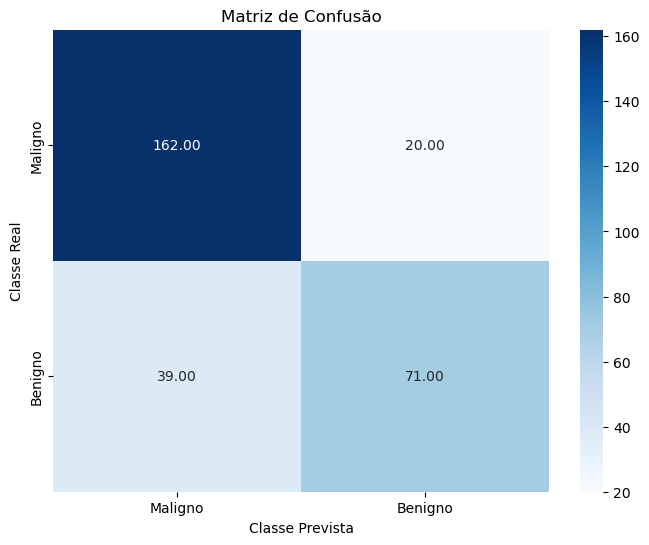


Accuracy: 0.80
Precision: 0.81
Recall: 0.89
Precision for negatives: 0.78
Recall for negatives: 0.65
F1 Score: 0.85
Average Log Loss: 0.44


In [156]:
model = xgb_r
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X_train_pca, y_train):
    X_train_fold, X_test_fold = X_train_pca.iloc[train_index], X_train_pca.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold)

y_pred = model.predict(X_test_pca)
y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    
conf_matrix = confusion_matrix(y_test, y_pred)
df_conf_matrix = pd.DataFrame(conf_matrix, index=['Maligno', 'Benigno'], columns=['Maligno', 'Benigno'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title('Matriz de Confusão')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()
print()

TP, FN, FP, TN = conf_matrix.ravel()

TP, FN, FP, TN = conf_matrix.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
precision_neg = TN / (TN + FN)
recall_neg = TN / (TN + FP)
f1 = 2 * (precision * recall) / (precision + recall)
average_log_loss = log_loss(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision for negatives: {precision_neg:.2f}")
print(f"Recall for negatives: {recall_neg:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Average Log Loss: {average_log_loss:.2f}")

# Conclusões XGBoost

O modelo está a prever com algum acerto (79% e 80% de accuracy) mas existe espaço para melhorias, como indicam as log losses de 0.45 e 0.44.
Existem diferenças ligeiras entre o modelo treinado para accuracy e o modelo treinado para recall, sendo que o modelo treinado para recall é ligeiramente melhor em todas as métricas, o que pode estar relacionado com o dataset se encontrar desbalnceado, com mais negativos do que positivos.
O dataset estar desbalanceado também se relaciona com o facto dos modelos terem valores de recall muito altos (88% e 89%), o que para o contexto do problema é muito positivo, e valores de negative recall muito baixos

# SVM

Fine Tuning do Support Vector Machine para o X_train usando a biblioteca Sklearn. Visto que no grid_search não é definido o 'scoring', o scoring é feito pela accuracy por default. Os valores do grid de parâmetros possíveis foram dados pelo ChatGPT através de contexto sobre o dataset (nº de componentes, tipo de classificação e modelo de classificação).
Nota para os parâmetros "pouco usuais" de 'degree' e 'coef0' que permitem ao modelo capturar a complexidade dos dados e assim evitar overfitting e underfitting. No modelo inicial é necessário colocar probability=True para depois se poder calcular a log loss quando o modelo for aplicado

In [163]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'coef0': [0.0, 0.1, 0.5], 
}
svm_classifier = SVC(random_state=42, probability=True)

grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, refit=True, cv=3, n_jobs=-1, verbose=3)

grid_search.fit(X_train_pca, y_train)

svm = grid_search.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV 1/3] END C=0.1, coef0=0.0, degree=2, gamma=scale, kernel=linear;, score=0.808 total time=   0.1s
[CV 3/3] END C=0.1, coef0=0.0, degree=2, gamma=scale, kernel=linear;, score=0.779 total time=   0.1s
[CV 1/3] END C=0.1, coef0=0.0, degree=2, gamma=scale, kernel=rbf;, score=0.654 total time=   0.1s
[CV 3/3] END C=0.1, coef0=0.0, degree=2, gamma=scale, kernel=rbf;, score=0.667 total time=   0.1s
[CV 2/3] END C=0.1, coef0=0.0, degree=2, gamma=scale, kernel=poly;, score=0.658 total time=   0.1s
[CV 1/3] END C=0.1, coef0=0.0, degree=2, gamma=auto, kernel=linear;, score=0.808 total time=   0.1s
[CV 3/3] END C=0.1, coef0=0.0, degree=2, gamma=auto, kernel=linear;, score=0.779 total time=   0.1s
[CV 2/3] END C=0.1, coef0=0.0, degree=2, gamma=auto, kernel=rbf;, score=0.658 total time=   0.1s
[CV 1/3] END C=0.1, coef0=0.0, degree=2, gamma=auto, kernel=poly;, score=0.642 total time=   0.1s
[CV 2/3] END C=0.1, coef0=0.0, degree=2, gamm

[CV 1/3] END C=1, coef0=0.0, degree=2, gamma=scale, kernel=poly;, score=0.654 total time=   0.1s
[CV 2/3] END C=1, coef0=0.0, degree=2, gamma=scale, kernel=poly;, score=0.688 total time=   0.1s
[CV 2/3] END C=1, coef0=0.0, degree=2, gamma=auto, kernel=linear;, score=0.692 total time=   0.2s
[CV 3/3] END C=1, coef0=0.0, degree=2, gamma=auto, kernel=linear;, score=0.704 total time=   0.1s
[CV 3/3] END C=1, coef0=0.0, degree=2, gamma=auto, kernel=rbf;, score=0.721 total time=   0.1s
[CV 1/3] END C=1, coef0=0.0, degree=2, gamma=auto, kernel=poly;, score=0.662 total time=   0.1s
[CV 1/3] END C=1, coef0=0.0, degree=3, gamma=scale, kernel=linear;, score=0.642 total time=   0.2s
[CV 2/3] END C=1, coef0=0.0, degree=3, gamma=scale, kernel=linear;, score=0.692 total time=   0.1s
[CV 1/3] END C=1, coef0=0.0, degree=3, gamma=scale, kernel=poly;, score=0.667 total time=   0.1s
[CV 2/3] END C=1, coef0=0.0, degree=3, gamma=scale, kernel=poly;, score=0.692 total time=   0.1s
[CV 2/3] END C=1, coef0=0.0

[CV 2/3] END C=10, coef0=0.0, degree=2, gamma=scale, kernel=rbf;, score=0.804 total time=   0.1s
[CV 3/3] END C=10, coef0=0.0, degree=2, gamma=scale, kernel=rbf;, score=0.808 total time=   0.1s
[CV 1/3] END C=10, coef0=0.0, degree=2, gamma=scale, kernel=poly;, score=0.688 total time=   0.1s
[CV 2/3] END C=10, coef0=0.0, degree=2, gamma=scale, kernel=poly;, score=0.633 total time=   0.1s
[CV 3/3] END C=10, coef0=0.0, degree=2, gamma=scale, kernel=poly;, score=0.604 total time=   0.1s
[CV 1/3] END C=10, coef0=0.0, degree=2, gamma=auto, kernel=linear;, score=0.596 total time=   0.3s
[CV 1/3] END C=10, coef0=0.0, degree=2, gamma=auto, kernel=rbf;, score=0.762 total time=   0.1s
[CV 2/3] END C=10, coef0=0.0, degree=2, gamma=auto, kernel=rbf;, score=0.762 total time=   0.2s
[CV 1/3] END C=10, coef0=0.0, degree=3, gamma=scale, kernel=linear;, score=0.596 total time=   0.3s
[CV 2/3] END C=10, coef0=0.0, degree=3, gamma=scale, kernel=linear;, score=0.646 total time=   0.4s
[CV 2/3] END C=10, co

Primeiro é feito um treino do modelo Support Vector Machine afinado para accuracy com 5-cross validation, utilizando o X_train e o y_train. Depois o modelo é testado com X_test e y_test, e é a partir destes testes que se retiram as métricas que considerámos relevantes (matriz de confusão, accuracy, precision, recall, precision for negatives, recall for negatives, f1 score e log loss)

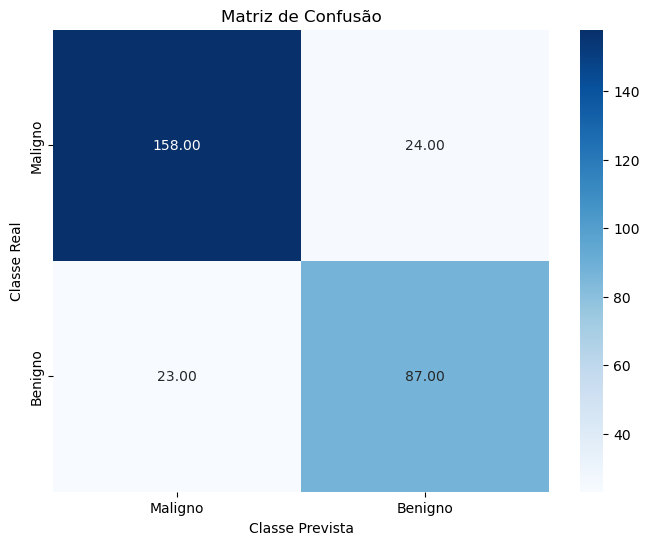


Accuracy: 0.84
Precision: 0.87
Recall: 0.87
Precision for negatives: 0.78
Recall for negatives: 0.79
F1 Score: 0.87
Average Log Loss: 0.40


In [164]:
model = svm
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X_train_pca, y_train):
    X_train_fold, X_test_fold = X_train_pca.iloc[train_index], X_train_pca.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold)

y_pred = model.predict(X_test_pca)
y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    
conf_matrix = confusion_matrix(y_test, y_pred)
df_conf_matrix = pd.DataFrame(conf_matrix, index=['Maligno', 'Benigno'], columns=['Maligno', 'Benigno'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title('Matriz de Confusão')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()
print()

TP, FN, FP, TN = conf_matrix.ravel()

TP, FN, FP, TN = conf_matrix.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
precision_neg = TN / (TN + FN)
recall_neg = TN / (TN + FP)
f1 = 2 * (precision * recall) / (precision + recall)
average_log_loss = log_loss(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision for negatives: {precision_neg:.2f}")
print(f"Recall for negatives: {recall_neg:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Average Log Loss: {average_log_loss:.2f}")

Outro Fine Tuning do Support Vector Machine para o X_train usando a biblioteca Sklearn, mas desta vez utilizando recall para o scoring do grid search, ao invés de accuracy. Neste caso utilizamos recall e não outra métrica devido ao contexto do problema, em que é mais importante não ter falsos negativos do que não ter falsos positivos. Os valores do grid de parâmetros possíveis foram dados pelo ChatGPT através de contexto sobre o dataset (nº de componentes, tipo de classificação e modelo de classificação). No modelo inicial é necessário colocar probability=True para depois se poder calcular a log loss quando o modelo for aplicado

In [165]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'coef0': [0.0, 0.1, 0.5], 
}
svm_classifier = SVC(random_state=42, probability=True)

grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, scoring = 'recall', refit=True, cv=3, n_jobs=-1, verbose=3)

grid_search.fit(X_train_pca, y_train)

svm_r = grid_search.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV 2/3] END C=100, coef0=0.0, degree=2, gamma=auto, kernel=rbf;, score=0.750 total time=   0.1s
[CV 3/3] END C=100, coef0=0.0, degree=2, gamma=auto, kernel=rbf;, score=0.779 total time=   0.1s
[CV 1/3] END C=100, coef0=0.0, degree=2, gamma=auto, kernel=poly;, score=0.671 total time=   0.1s
[CV 2/3] END C=100, coef0=0.0, degree=2, gamma=auto, kernel=poly;, score=0.625 total time=   0.1s
[CV 3/3] END C=100, coef0=0.0, degree=2, gamma=auto, kernel=poly;, score=0.583 total time=   0.1s
[CV 1/3] END C=100, coef0=0.0, degree=3, gamma=scale, kernel=linear;, score=0.596 total time=   0.4s
[CV 2/3] END C=100, coef0=0.0, degree=3, gamma=scale, kernel=linear;, score=0.658 total time=   0.6s
[CV 2/3] END C=100, coef0=0.0, degree=3, gamma=auto, kernel=linear;, score=0.658 total time=   0.6s
[CV 3/3] END C=100, coef0=0.0, degree=3, gamma=auto, kernel=linear;, score=0.675 total time=   0.2s
[CV 3/3] END C=100, coef0=0.0, degree=4, gamma=

[CV 1/3] END C=0.1, coef0=0.0, degree=2, gamma=auto, kernel=linear;, score=0.795 total time=   0.1s
[CV 1/3] END C=0.1, coef0=0.0, degree=2, gamma=auto, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=0.1, coef0=0.0, degree=2, gamma=auto, kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/3] END C=0.1, coef0=0.0, degree=2, gamma=auto, kernel=poly;, score=0.122 total time=   0.1s
[CV 3/3] END C=0.1, coef0=0.0, degree=2, gamma=auto, kernel=poly;, score=0.146 total time=   0.1s
[CV 3/3] END C=0.1, coef0=0.0, degree=3, gamma=scale, kernel=linear;, score=0.634 total time=   0.1s
[CV 1/3] END C=0.1, coef0=0.0, degree=3, gamma=scale, kernel=rbf;, score=0.000 total time=   0.1s
[CV 1/3] END C=0.1, coef0=0.0, degree=3, gamma=scale, kernel=poly;, score=0.000 total time=   0.1s
[CV 2/3] END C=0.1, coef0=0.0, degree=3, gamma=scale, kernel=poly;, score=0.012 total time=   0.1s
[CV 2/3] END C=0.1, coef0=0.0, degree=3, gamma=auto, kernel=linear;, score=0.537 total time=   0.1s
[CV 3/3] END 

[CV 1/3] END C=0.1, coef0=0.5, degree=4, gamma=auto, kernel=poly;, score=0.602 total time=   0.1s
[CV 2/3] END C=0.1, coef0=0.5, degree=4, gamma=auto, kernel=poly;, score=0.293 total time=   0.1s
[CV 3/3] END C=0.1, coef0=0.5, degree=4, gamma=auto, kernel=poly;, score=0.378 total time=   0.1s
[CV 3/3] END C=1, coef0=0.0, degree=2, gamma=scale, kernel=linear;, score=0.622 total time=   0.1s
[CV 1/3] END C=1, coef0=0.0, degree=2, gamma=scale, kernel=rbf;, score=0.663 total time=   0.1s
[CV 2/3] END C=1, coef0=0.0, degree=2, gamma=scale, kernel=rbf;, score=0.341 total time=   0.1s
[CV 3/3] END C=1, coef0=0.0, degree=2, gamma=scale, kernel=rbf;, score=0.317 total time=   0.1s
[CV 2/3] END C=1, coef0=0.0, degree=2, gamma=auto, kernel=linear;, score=0.573 total time=   0.1s
[CV 3/3] END C=1, coef0=0.0, degree=2, gamma=auto, kernel=linear;, score=0.622 total time=   0.1s
[CV 3/3] END C=1, coef0=0.0, degree=2, gamma=auto, kernel=rbf;, score=0.293 total time=   0.1s
[CV 1/3] END C=1, coef0=0.0,

[CV 3/3] END C=10, coef0=0.0, degree=4, gamma=scale, kernel=poly;, score=0.256 total time=   0.1s
[CV 1/3] END C=10, coef0=0.0, degree=4, gamma=auto, kernel=linear;, score=0.651 total time=   0.3s
[CV 1/3] END C=10, coef0=0.0, degree=4, gamma=auto, kernel=rbf;, score=0.639 total time=   0.1s
[CV 2/3] END C=10, coef0=0.0, degree=4, gamma=auto, kernel=rbf;, score=0.390 total time=   0.1s
[CV 2/3] END C=10, coef0=0.0, degree=4, gamma=auto, kernel=poly;, score=0.305 total time=   0.1s
[CV 3/3] END C=10, coef0=0.0, degree=4, gamma=auto, kernel=poly;, score=0.451 total time=   0.1s
[CV 3/3] END C=10, coef0=0.1, degree=2, gamma=scale, kernel=linear;, score=0.598 total time=   0.2s
[CV 1/3] END C=10, coef0=0.1, degree=2, gamma=scale, kernel=rbf;, score=0.807 total time=   0.1s
[CV 2/3] END C=10, coef0=0.1, degree=2, gamma=scale, kernel=rbf;, score=0.524 total time=   0.1s
[CV 3/3] END C=10, coef0=0.1, degree=2, gamma=scale, kernel=rbf;, score=0.634 total time=   0.1s
[CV 1/3] END C=10, coef0=0

Primeiro é feito um treino do modelo Support Vector Machine afinado para recall com 5-cross validation, utilizando o X_train e o y_train. Depois o modelo é testado com X_test e y_test, e é a partir destes testes que se retiram as métricas que considerámos relevantes (matriz de confusão, accuracy, precision, recall, precision for negatives, recall for negatives, f1 score e log loss)

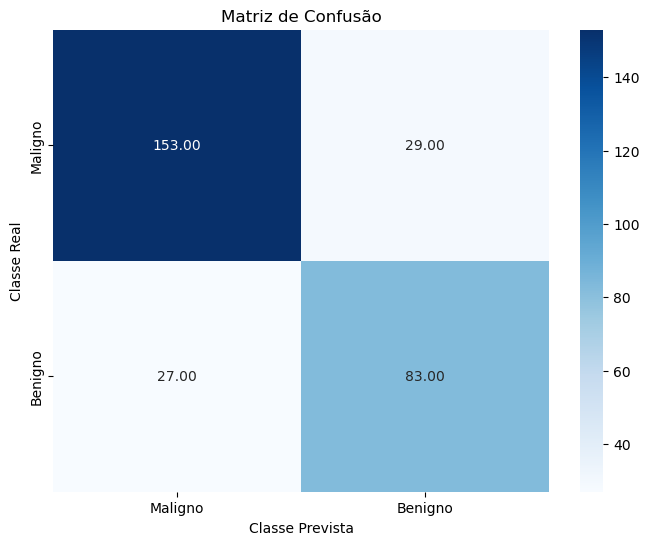


Accuracy: 0.81
Precision: 0.85
Recall: 0.84
Precision for negatives: 0.74
Recall for negatives: 0.75
F1 Score: 0.85
Average Log Loss: 0.47


In [166]:
model = svm_r
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X_train_pca, y_train):
    X_train_fold, X_test_fold = X_train_pca.iloc[train_index], X_train_pca.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold)

y_pred = model.predict(X_test_pca)
y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    
conf_matrix = confusion_matrix(y_test, y_pred)
df_conf_matrix = pd.DataFrame(conf_matrix, index=['Maligno', 'Benigno'], columns=['Maligno', 'Benigno'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title('Matriz de Confusão')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()
print()

TP, FN, FP, TN = conf_matrix.ravel()

TP, FN, FP, TN = conf_matrix.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
precision_neg = TN / (TN + FN)
recall_neg = TN / (TN + FP)
f1 = 2 * (precision * recall) / (precision + recall)
average_log_loss = log_loss(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision for negatives: {precision_neg:.2f}")
print(f"Recall for negatives: {recall_neg:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Average Log Loss: {average_log_loss:.2f}")

# Conclusões SVM

O modelo está a prever com algum acerto (84% e 81% de accuracy) mas existe espaço para melhorias, como indicam as log losses de 0.40 e 0.47.
Existem diferenças entre o modelo treinado para accuracy e o modelo treinado para recall, sendo que o modelo treinado para accuracy tem melhores valores em todas as métricas. Isto deve-se ao modelo lidar melhor com dados balanceados, e tendo em conta que o dataset já é desbalanceado, o treino com foco na classe maioritária só piora o seu desempenho.

# Random Forest

Fine Tuning do Random Forest para o X_train usando a biblioteca Sklearn. Visto que no grid_search não é definido o 'scoring', o scoring é feito pela accuracy por default. Os valores do grid de parâmetros possíveis foram dados pelo ChatGPT através de contexto sobre o dataset (nº de componentes, tipo de classificação e modelo de classificação). No modelo inicial é necessário colocar oob_score=True para depois se poder calcular a log loss quando o modelo for aplicado

In [174]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf_classifier = RandomForestClassifier(random_state=42, oob_score=True)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, refit=True, cv=3, n_jobs=-1, verbose=3)

grid_search.fit(X_train_pca, y_train)

rf = grid_search.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.708 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.679 total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.708 total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.700 total time=   1.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.692 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.679 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.696 tota

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.675 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.717 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.713 total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.662 total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.717 total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.704 total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=500;, score=0.679 total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=None, min

[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=500;, score=0.667 total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=500;, score=0.721 total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.700 total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=0.679 total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=0.704 total time=   1.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.700 total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=0.679 total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=

[CV 1/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.721 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.708 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.729 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.683 total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.721 total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=0.700 total time=   1.5s
[CV 1/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.688 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=30, min_samples_leaf=4

[CV 1/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_s

[CV 3/3] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=20, min_samples_leaf=4, mi

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
324 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 437, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only available if bootstrap=True

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/o

Primeiro é feito um treino do modelo Random Forest afinado para accuracy com 5-cross validation, utilizando o X_train e o y_train. Depois o modelo é testado com X_test e y_test, e é a partir destes testes que se retiram as métricas que considerámos relevantes (matriz de confusão, accuracy, precision, recall, precision for negatives, recall for negatives, f1 score e log loss)

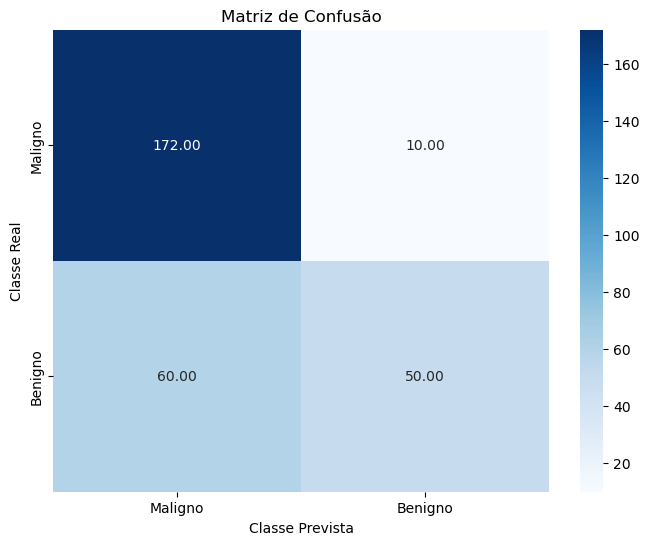


Accuracy: 0.76
Precision: 0.74
Recall: 0.95
Precision for negatives: 0.83
Recall for negatives: 0.45
F1 Score: 0.83
Average Log Loss: 0.56


In [175]:
model = rf
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X_train_pca, y_train):
    X_train_fold, X_test_fold = X_train_pca.iloc[train_index], X_train_pca.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold)

y_pred = model.predict(X_test_pca)
y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    
conf_matrix = confusion_matrix(y_test, y_pred)
df_conf_matrix = pd.DataFrame(conf_matrix, index=['Maligno', 'Benigno'], columns=['Maligno', 'Benigno'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title('Matriz de Confusão')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()
print()

TP, FN, FP, TN = conf_matrix.ravel()

TP, FN, FP, TN = conf_matrix.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
precision_neg = TN / (TN + FN)
recall_neg = TN / (TN + FP)
f1 = 2 * (precision * recall) / (precision + recall)
average_log_loss = log_loss(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision for negatives: {precision_neg:.2f}")
print(f"Recall for negatives: {recall_neg:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Average Log Loss: {average_log_loss:.2f}")

Outro Fine Tuning do Randm Forest para o X_train usando a biblioteca Sklearn, mas desta vez utilizando recall para o scoring do grid search, ao invés de accuracy. Neste caso utilizamos recall e não outra métrica devido ao contexto do problema, em que é mais importante não ter falsos negativos do que não ter falsos positivos. Os valores do grid de parâmetros possíveis foram dados pelo ChatGPT através de contexto sobre o dataset (nº de componentes, tipo de classificação e modelo de classificação). No modelo inicial é necessário colocar oob_score=True para depois se poder calcular a log loss quando o modelo for aplicado

In [179]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf_classifier = RandomForestClassifier(random_state=42, oob_score=True)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='recall', refit=True, cv=3, n_jobs=-1, verbose=3)

grid_search.fit(X_train_pca, y_train)

rf_r = grid_search.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.207 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.181 total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.207 total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.171 total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.217 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.183 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.244 tota

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.205 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.244 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.195 total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.108 total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.232 total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.195 total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=500;, score=0.181 total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=None, min

[CV 3/3] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.207 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.145 total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.207 total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=500;, score=0.146 total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.241 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.171 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.256 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=20, min_samples_lea

[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=0.183 total time=   1.3s
[CV 2/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.146 total time=   0.5s
[CV 1/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=0.108 total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.120 total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.159 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.280 total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.108 total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=30, min_samples_lea

[CV 1/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_s

[CV 3/3] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=20, min_samples_leaf=4,

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
324 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 437, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only available if bootstrap=True

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/o

Primeiro é feito um treino do modelo Random Forest afinado para recall com 5-cross validation, utilizando o X_train e o y_train. Depois o modelo é testado com X_test e y_test, e é a partir destes testes que se retiram as métricas que considerámos relevantes (matriz de confusão, accuracy, precision, recall, precision for negatives, recall for negatives, f1 score e log loss)

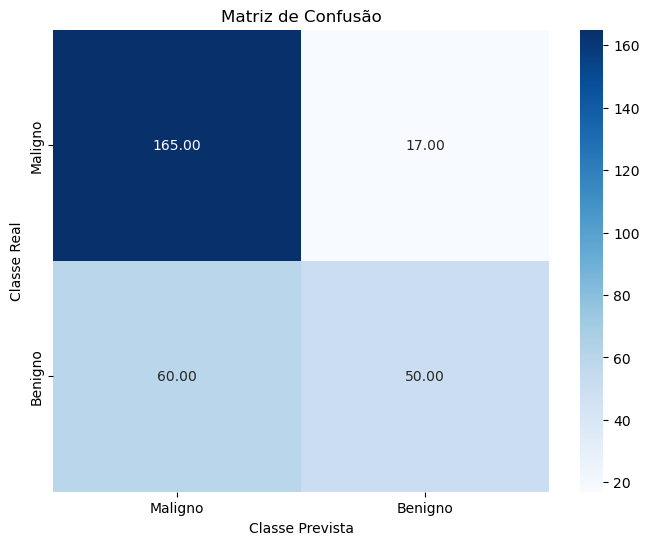


Accuracy: 0.74
Precision: 0.73
Recall: 0.91
Precision for negatives: 0.75
Recall for negatives: 0.45
F1 Score: 0.81
Average Log Loss: 0.59
[CV 1/3] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=500;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=500;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=500;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=30, min_samples_lea

In [180]:
model = rf_r
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X_train_pca, y_train):
    X_train_fold, X_test_fold = X_train_pca.iloc[train_index], X_train_pca.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold)

y_pred = model.predict(X_test_pca)
y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    
conf_matrix = confusion_matrix(y_test, y_pred)
df_conf_matrix = pd.DataFrame(conf_matrix, index=['Maligno', 'Benigno'], columns=['Maligno', 'Benigno'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title('Matriz de Confusão')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()
print()

TP, FN, FP, TN = conf_matrix.ravel()

TP, FN, FP, TN = conf_matrix.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
precision_neg = TN / (TN + FN)
recall_neg = TN / (TN + FP)
f1 = 2 * (precision * recall) / (precision + recall)
average_log_loss = log_loss(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision for negatives: {precision_neg:.2f}")
print(f"Recall for negatives: {recall_neg:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Average Log Loss: {average_log_loss:.2f}")

# Conclusões Random Forest

O modelo está a prever com pouco acerto (76% e 74% de accuracy) e existe espaço para melhorias, como indicam as log losses de 0.56 e 0.59.
Existem diferenças entre o modelo treinado para accuracy e o modelo treinado para recall, sendo que o modelo treinado para accuracy tem melhores valores em todas as métricas.
Apesar do pouco acerto, o modelo está a fazer overfitting nos dados (naturalmente desbalanceados), o que neste contexto acaba por ser positivo, pois tem valores altíssimos de recall (95% e 91%)

# Comparação de modelos

O Support Vector Machine acaba por ser o mais adequado para este problema (em que o recall é importante), visto que tem o f1 score (trade-off entre accuracy e recall) mais alto. O Random Forest é o melhor a prever os casos negativos (tem um recall de 95%) o que também pode ser muito positivo neste contexto. O XGBoost acaba por ser o mais equilibrado, pois tem melhor accuracy que o Random Forest e melhor recall que o Support Vector Machine.

# Emsembles

Emsemble dos 3 modelos com melhores métricas (XGBoost afinado para recall, SVM afinado para accuracy e Random Forest afinado para accuracy), com voting soft, o que significa que combina as probabilidades da previsão de cada modelo para fazer uma previsão. Mais uma vez o modelo (neste caso o emsemble) é treinado com 5-cross validation nos dados de teste, e é testado nos dados de teste, de onde saem as métricas

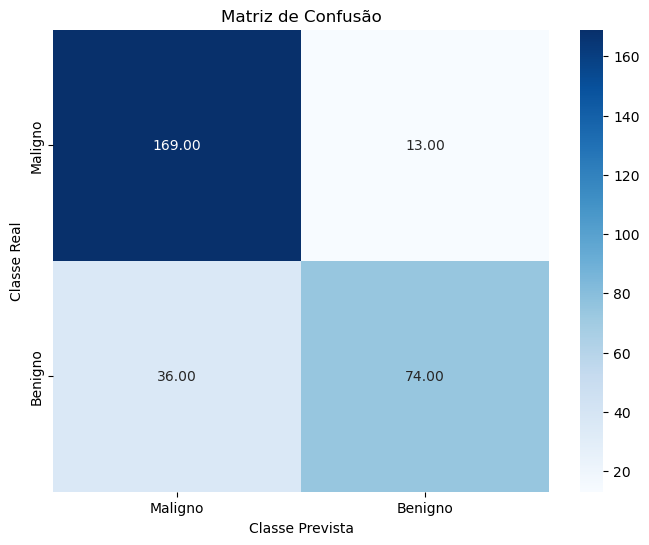


Accuracy: 0.83
Precision: 0.82
Recall: 0.93
Precision for negatives: 0.85
Recall for negatives: 0.67
F1 Score: 0.87
Average Log Loss: 0.44


In [181]:
model = VotingClassifier(estimators=[
    ('xgb_r', xgb_r),
    ('svm', svm),
    ('rf', rf)
], voting='soft') 

X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X_train_pca, y_train):
    X_train_fold, X_test_fold = X_train_pca.iloc[train_index], X_train_pca.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold)

y_pred = model.predict(X_test_pca)
y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    
conf_matrix = confusion_matrix(y_test, y_pred)
df_conf_matrix = pd.DataFrame(conf_matrix, index=['Maligno', 'Benigno'], columns=['Maligno', 'Benigno'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title('Matriz de Confusão')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()
print()

TP, FN, FP, TN = conf_matrix.ravel()

TP, FN, FP, TN = conf_matrix.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
precision_neg = TN / (TN + FN)
recall_neg = TN / (TN + FP)
f1 = 2 * (precision * recall) / (precision + recall)
average_log_loss = log_loss(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision for negatives: {precision_neg:.2f}")
print(f"Recall for negatives: {recall_neg:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Average Log Loss: {average_log_loss:.2f}")

Emsemble dos 2 modelos com melhor accuracy (XGBoost afinado para recall e SVM afinado para accuracy). Ensemble feito com voting soft, o que significa que combina as probabilidades da previsão de cada modelo para fazer uma previsão. Mais uma vez o modelo (neste caso o emsemble) é treinado com 5-cross validation nos dados de teste, e é testado nos dados de teste, de onde saem as métricas

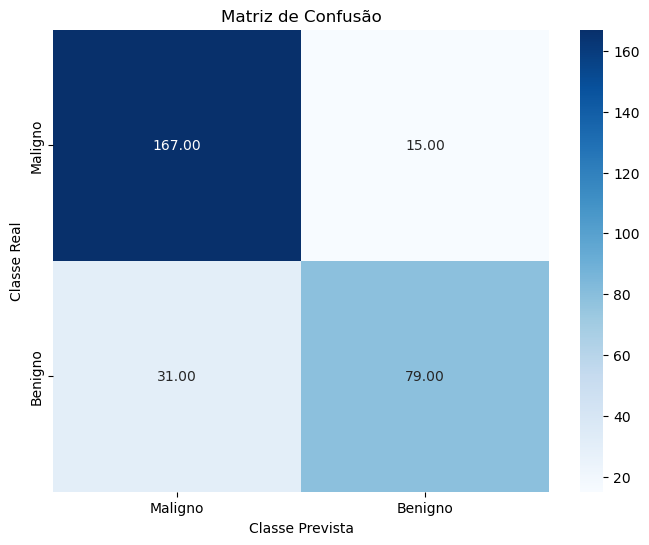


Accuracy: 0.84
Precision: 0.84
Recall: 0.92
Precision for negatives: 0.84
Recall for negatives: 0.72
F1 Score: 0.88
Average Log Loss: 0.40


In [182]:
model = VotingClassifier(estimators=[
    ('xgb_r', xgb_r),
    ('svm', svm)
], voting='soft') 

X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X_train_pca, y_train):
    X_train_fold, X_test_fold = X_train_pca.iloc[train_index], X_train_pca.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold)

y_pred = model.predict(X_test_pca)
y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    
conf_matrix = confusion_matrix(y_test, y_pred)
df_conf_matrix = pd.DataFrame(conf_matrix, index=['Maligno', 'Benigno'], columns=['Maligno', 'Benigno'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title('Matriz de Confusão')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()
print()

TP, FN, FP, TN = conf_matrix.ravel()

TP, FN, FP, TN = conf_matrix.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
precision_neg = TN / (TN + FN)
recall_neg = TN / (TN + FP)
f1 = 2 * (precision * recall) / (precision + recall)
average_log_loss = log_loss(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision for negatives: {precision_neg:.2f}")
print(f"Recall for negatives: {recall_neg:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Average Log Loss: {average_log_loss:.2f}")

Emsemble dos 2 modelos com melhor accuracy (XGBoost afinado para recall e Random Forest afinado para accuracy). Ensemble feito com voting soft, o que significa que combina as probabilidades da previsão de cada modelo para fazer uma previsão. Mais uma vez o modelo (neste caso o emsemble) é treinado com 5-cross validation nos dados de teste, e é testado nos dados de teste, de onde saem as métricas

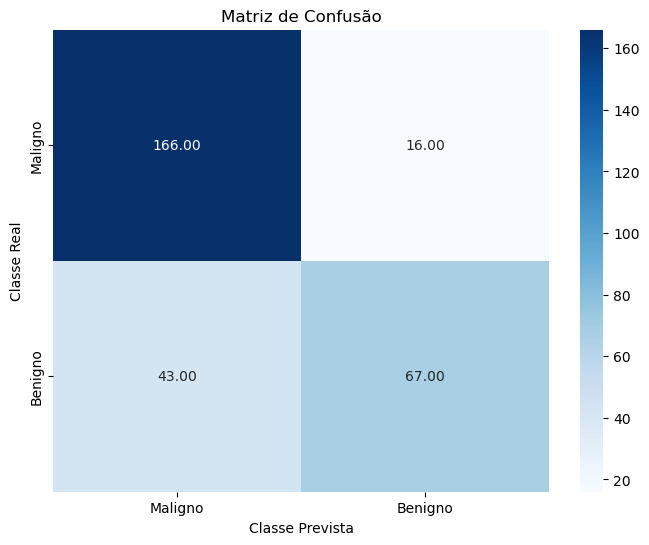


Accuracy: 0.80
Precision: 0.79
Recall: 0.91
Precision for negatives: 0.81
Recall for negatives: 0.61
F1 Score: 0.85
Average Log Loss: 0.48


In [183]:
model = VotingClassifier(estimators=[
    ('xgb_r', xgb_r),
    ('rf', rf)
], voting='soft') 

X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X_train_pca, y_train):
    X_train_fold, X_test_fold = X_train_pca.iloc[train_index], X_train_pca.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold)

y_pred = model.predict(X_test_pca)
y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    
conf_matrix = confusion_matrix(y_test, y_pred)
df_conf_matrix = pd.DataFrame(conf_matrix, index=['Maligno', 'Benigno'], columns=['Maligno', 'Benigno'])

plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title('Matriz de Confusão')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()
print()

TP, FN, FP, TN = conf_matrix.ravel()

TP, FN, FP, TN = conf_matrix.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
precision_neg = TN / (TN + FN)
recall_neg = TN / (TN + FP)
f1 = 2 * (precision * recall) / (precision + recall)
average_log_loss = log_loss(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision for negatives: {precision_neg:.2f}")
print(f"Recall for negatives: {recall_neg:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Average Log Loss: {average_log_loss:.2f}")

# Conclusões Ensembles

O Ensemble entre os três melhores modelos acaba por ser o melhor, com um f1 score alto (87%), um recall alto (93%) e uma accuracy alta (83%). Se o compararmos com os modelos individuais também acaba por ser o mais equilibrado.
Em relação aos Ensembles que combinam os dois melhores modelos para accuracy e os dois melhores modelos para recall os resultados não são positivos, pois os melhores modelos individuais em termos de accuracy e recall têm melhores resultados nessas métricas do que os ensembles com esse propósito, o que acaba por tornar estes ensembles pouco úteis.